In this notebook we will explore the possibilities of fitting a maximum likelihood estimator using neural networks. The idea is as follows: Using the probability density of the gaussian distribution:
$$f_{\mu, \sigma}(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{(x-\mu)^2}{2\sigma^2}\right)$$

We can deduce the log-likelihood function assuming independence of the observations:

$$\ell(\mu, \sigma|x) \propto -\sum_{i=1}^n\log(\sigma_i^2) + \sum_{i=1}^n\left(\frac{(x_i-\mu_i)^2}{2\sigma^2}\right)$$

Note the subscript $i$ for the mean and standard deviation. We want a single neural network to model both functions simultaneously. Therefore, we must optimise the network for both variables simultaneously. For this, we will use pytorch

The loss function of the network will be the log-likelihood function in which we give a neural network layer as input. 

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

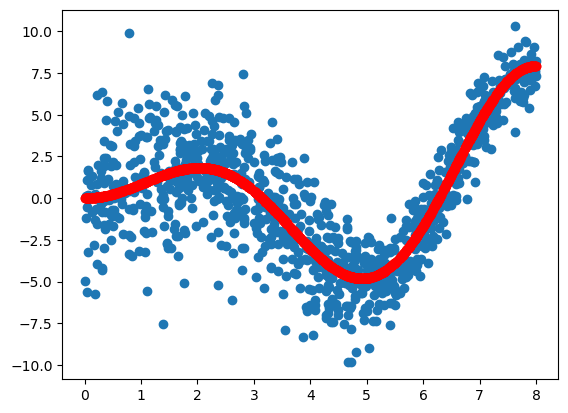

In [30]:
N = 1500 # 2500 part for validation
x = np.random.uniform(0, 8, N)

funMean = lambda x: x*np.sin(x)
funStdev = lambda x: 3 - x/4
y_true_mean = funMean(x)
y_true_stdev = funStdev(x)

y = y_true_mean + np.random.normal(0, y_true_stdev, N)


x = torch.FloatTensor(x).unsqueeze(1) 
y = torch.FloatTensor(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3333, random_state=42)

plt.scatter(x_train, y_train)
plt.scatter(x, y_true_mean, color="red")

Convert the data to pytorch tensors

In [31]:

class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(1, 8)
        self.layer2 = nn.Linear(8, 8)
       
        self.nodeMean = nn.Linear(8, 1)
        self.nodeStdev = nn.Linear(8, 1)
        self.softplus = nn.Softplus()
        self.ReLU = nn.ReLU()

    def forward(self, x):
        
        x = self.softplus(self.layer1(x))
        x = self.softplus(self.layer2(x))

        mean = self.nodeMean(x)
        stdev = self.softplus(self.nodeStdev(x))
        
        return mean, stdev

def createModelMLE():
    model = SimpleNeuralNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  
    return model, optimizer

x = torch.FloatTensor(x).unsqueeze(1) 
y = torch.FloatTensor(y)

modelLinear, optimizer = createModelMLE()

# Training the model
best_loss = float('inf')
num_epochs = 20000
patience = 10

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    mean, stdev = modelLinear(x)
    loss = nn.GaussianNLLLoss()(mean.squeeze(), y, stdev.squeeze()**2)
    loss.backward()
    optimizer.step()

    

    # Early stopping 
    if loss < best_loss:
        best_loss = loss
        best_model_weights = copy.deepcopy(modelLinear.state_dict())
        patience = 50
    else: 
        patience -= 1
        if patience == 0:
            break
        
    if (epoch + 1) % 100 == 0:
        
        meanTrain, _ = modelLinear(x)
        mseTrain = torch.mean((meanTrain.squeeze() - y) ** 2)
        meanTest, _ = modelLinear(x_test)
        mseTest = torch.mean((meanTest.squeeze() - y_test) ** 2)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, In-sample Error: {mseTrain.item():.4f}, Out-of-sample Error: {mseTest.item():.4f}")

Epoch [100/20000], Loss: 1.8901, In-sample Error: 15.8043, Out-of-sample Error: 16.2162
Epoch [200/20000], Loss: 1.8160, In-sample Error: 15.6849, Out-of-sample Error: 16.0448
Epoch [300/20000], Loss: 1.8109, In-sample Error: 15.6729, Out-of-sample Error: 16.0412
Epoch [400/20000], Loss: 1.8095, In-sample Error: 15.6566, Out-of-sample Error: 16.0261
Epoch [500/20000], Loss: 1.8084, In-sample Error: 15.6370, Out-of-sample Error: 16.0054
Epoch [600/20000], Loss: 1.8074, In-sample Error: 15.6186, Out-of-sample Error: 15.9876
Epoch [700/20000], Loss: 1.8065, In-sample Error: 15.6021, Out-of-sample Error: 15.9739
Epoch [800/20000], Loss: 1.8055, In-sample Error: 15.5869, Out-of-sample Error: 15.9642
Epoch [900/20000], Loss: 1.8044, In-sample Error: 15.5722, Out-of-sample Error: 15.9577
Epoch [1000/20000], Loss: 1.8032, In-sample Error: 15.5570, Out-of-sample Error: 15.9537
Epoch [1100/20000], Loss: 1.8017, In-sample Error: 15.5396, Out-of-sample Error: 15.9506
Epoch [1200/20000], Loss: 1.80

Now that we have fit the model, we need to get the values in the second-last layer of the network, as they must theoretically represent $\mu$ and $\sigma$ that is used as input in the log-likelihood function.

In red we will plot the true function and generated datapoints.
In blue we will plot the neural network function of the mean and the 95% interval in which the generated points must lie accoring to the formula $\mu\pm1.96\sigma$.

The fit is works well, even for a relatively simple network. At this point I feel no need to verify using cross-validation.

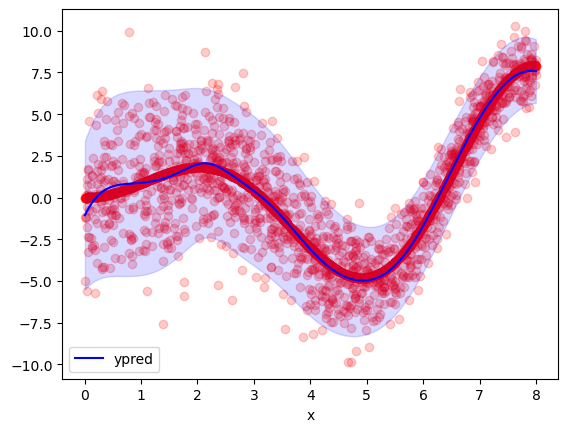

In [33]:
x_list = x.detach().cpu().numpy().flatten()
mean_list = mean.detach().cpu().numpy().flatten()
stdev_list = stdev.detach().cpu().numpy().flatten()

df = pd.DataFrame({"x": x_list, "y": y, "ypred": mean_list, "stdev": stdev_list,
                   "predIntervalUpper": mean_list + 1.96*stdev_list,
                   "predIntervalLower": mean_list - 1.96*stdev_list,
                   })
df = df.sort_values("x")

ax = df.plot(x="x", y=["ypred"], color="blue")

ax.scatter(x, y_true_mean, color="red", alpha=.5)
ax.scatter(df["x"], df["y"], color='red', label="Data Points", alpha=.2)
ax.fill_between(df["x"], df["predIntervalLower"], df["predIntervalUpper"], 
                color='blue', alpha=0.15, label="Prediction Interval")